In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from operator import itemgetter

from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

Начальные стандартные параметры модели. В основном используются для дебага модели. В своей реализации не буду использовать сетку. Будем считать, что все агенты находятся недалеко от друг друга и все могут контактировать со всеми. 

In [2]:
TOTAL_AGENT = 100 # aka N
N_STEPS = 10 
EXTREMIST_PROPORTION = 0.1 # aka Pe
UNCERTAINTY_EXTREMIST = 0.1
EXTREMIST_OPINION = 0.1 # aka Ue
UNCERTAINTY_AGENTS = 1 # aka U
AGENT_OPINION = 0.2
DELTA_POS_NEG = 0.5 # aka sigma
MU = 0.5

Все вычисления постарался векторизовать, вроде удалось и все нормально происходит. Сначала создаются агенты с ультралевой позицией (-1), затем агенты с ультраправой позицией (+1). Количество таких агентов определяется параметрами EXTREMIST_PROPORTION и DELTA_POS_NEG. Остальные агенты являются нейтральными. 

Метод make_disscussion представляет собой взаимодействие агентов, когда они поделятся мнениями между собой, реализация изменения мнения агента происходит только после того, как каждый агент пообщался с каждым другим агентом. Общее изменение мнений агентов реализовано согласно оригинальной статьи 2002 года. 

При помощи метода step активируется метод make_disscussion, но новое мнение агенту присваивается только после того, как каждый агент оказал влияние на другого агента, при помощи метода advance.

In [3]:
class OpinionAgent(Agent):
    def __init__(self, unique_id, model, TOTAL_AGENT, EXTREMIST_PROPORTION, DELTA_POS_NEG,
                EXTREMIST_OPINION, UNCERTAINTY_EXTREMIST, AGENT_OPINION, UNCERTAINTY_AGENTS, MU):
        super().__init__(unique_id, model)
        self.id_agent = unique_id
        np.random.seed(unique_id) # добавим немного детерменированности 
        neg_ext = TOTAL_AGENT * EXTREMIST_PROPORTION * DELTA_POS_NEG
        pos_ext = TOTAL_AGENT * EXTREMIST_PROPORTION
        if unique_id < neg_ext:
            self.opinion = np.random.uniform(-1, -1+EXTREMIST_OPINION)
            self.uncertainty_left = np.max([self.opinion-UNCERTAINTY_EXTREMIST, -1])
            self.uncertainty_right = self.opinion+UNCERTAINTY_EXTREMIST
        elif unique_id <= pos_ext and unique_id >= neg_ext:
            self.opinion = np.random.uniform(1-EXTREMIST_OPINION, 1)
            self.uncertainty_left = np.max([self.opinion-EXTREMIST_OPINION, -1])
            self.uncertainty_right = np.min([self.opinion+EXTREMIST_OPINION, 1])
        else:
            self.opinion = np.random.uniform(-1+AGENT_OPINION, 1-AGENT_OPINION)
            self.uncertainty_left = np.max([self.opinion-UNCERTAINTY_AGENTS, -1])
            self.uncertainty_right = np.min([self.opinion+UNCERTAINTY_AGENTS, 1])
        self.mean_relative_agreement = 0
        self.mu = MU
    
    def make_disscussion(self):
        all_agents_idx = list(range(TOTAL_AGENT))
        all_agents_idx.remove(self.id_agent)
        all_agents = self.model.schedule.agents.copy()
        
        xj = np.array(self.opinion)
        uj = np.array(self.uncertainty_right - xj)
        
        agents_to_contact = list(itemgetter(*all_agents_idx)(all_agents))
        
        xii = np.array([x.opinion for x in agents_to_contact])
        uii = np.array([x.uncertainty_right for x in agents_to_contact]) - xii
        
        overlap = np.min(((xj+uj).repeat(xii.shape[0]), xii+uii), axis=0) - \
                  np.max(((xj-uj).repeat(xii.shape[0]), xii-uii), axis=0)
        non_overlapping = 2*(uii) - overlap
        agreement = overlap - non_overlapping
        relative_agreement = overlap/uii - 1
        
        opinion_idx = np.where(overlap > uii)
        if len(opinion_idx) != 0:
            change_on_xj = xj+self.mu*relative_agreement[opinion_idx]*(xii[opinion_idx]-xj)
            change_on_uj = uj+self.mu*relative_agreement[opinion_idx]*(uii[opinion_idx]-uj)
            xj_new, uj_new = np.mean(change_on_xj[~np.isnan(change_on_xj)]), np.mean(change_on_uj[~np.isnan(change_on_uj)])
        else:
            xj_new, uj_new = xj, uj
            
        ra_not_na = relative_agreement[opinion_idx]
        if len(ra_not_na) == 0:
            self.mean_relative_agreement = 1
        else:
            self.mean_relative_agreement = np.mean(ra_not_na)    
        
        return xj_new, uj_new
        
    def step(self):
        self.new_xj, self.new_uj = self.make_disscussion()
        
    def advance(self):
        self.opinion = self.new_xj
        self.uncertainty_left = self.new_xj - self.new_uj
        self.uncertainty_right = self.new_xj + self.new_uj  

Создадим функции, которые будут отслеживать состояние системы. Сразу тогда опишем как будем считать сходимость модели.

Под сходимостью будем понимать такое состояние, когда мнение агентов больше не изменяется, то есть мнение с соседями полностью идентично и больше никто ни на кого не оказывает влияния. Мнение агента в таком случае определено и больше не может измениться потому что больше не находиться других агентов, с которыми может возникнуть пересечения мнения. Такую сходимость будем называть абсолютной. 

Под относительной сходимостью понимаем, когда существуют еще агенты, мнение которых до сих пор изменяется, но очень медленно и не существенно. 

Отслеживать изменение мнений агентов будем при помощи параметра mean_relative_agreement (среднего соглашения агентов). mean_relative_agreement близок к нулю, когда агенты могут оказать влияние друг на друга, и равен единице, когда у всех агентов абсолютно сходятся мнения относительно агентов, которые могут оказать влияние друг на друга. 

Помимо самой сходимости система может сойтись к 3-м основным состояниям, описанным в оригинальной статье 2002 года. Когда индикатор близок к нулю, то система пришла к центральному состоянию, то есть агенты не пришли к ультраправым или к ультралевым и остались где-то при среднем мнении. Когда индикатор близок к 0.5 - агенты пришли к биполярному состоянию. В основном существует либо крайне левый взгляд, либо крайне правый. А если индикатор близок к единице, то система пришла к одному из экстремистских мнений. 

При помощи функции compute_relative_agreement считается сходимость всей системы. Функция compute_mean_opinion считает среднее мнение системы. А функция compute_convergence_type считает тип сходимости системы.

In [4]:
def compute_relative_agreement(model):
    agent_relative_agreement = [agent.mean_relative_agreement for agent in model.schedule.agents]
    return np.mean(agent_relative_agreement, axis=0)

def compute_mean_opinion(model):
    agent_opinion = [agent.opinion for agent in model.schedule.agents]
    agent_opinion = np.array(agent_opinion)[~np.isnan(agent_opinion)]
    return np.mean(agent_opinion, axis=0)

def compute_convergence_type(model):
    total_agents = model.TOTAL_AGENT
    normal_agents = int(total_agents * (1-model.EXTREMIST_PROPORTION))
    ultra_agents = total_agents - normal_agents
    negative_agents = int(ultra_agents * model.DELTA_POS_NEG)
    possitive_agents = int(ultra_agents * (1-model.DELTA_POS_NEG))

    agent_opinion = [agent.opinion for agent in model.schedule.agents]
    agent_opinion = np.array(agent_opinion)[~np.isnan(agent_opinion)]

    PROPORTION_ULTA_POSITIVE = (np.sum(np.where(np.array(agent_opinion) > 0.8, 1, 0)) - possitive_agents) / normal_agents
    PROPORTION_ULTA_NEGATIVE = (np.sum(np.where(np.array(agent_opinion) < -0.8, 1, 0)) - negative_agents) / normal_agents

    y = PROPORTION_ULTA_POSITIVE**2 + PROPORTION_ULTA_NEGATIVE**2
    
    return y 

А здесь сама модель. Все очень просто - модель создает агентов, заставляет их взаимодействовать друг с другом и записывает состояние системы на текущий момент.

In [5]:
class ContactModel(Model):
    def __init__(self, TOTAL_AGENT, EXTREMIST_PROPORTION, DELTA_POS_NEG,
                EXTREMIST_OPINION, UNCERTAINTY_EXTREMIST, AGENT_OPINION, UNCERTAINTY_AGENTS, MU):
        self.TOTAL_AGENT = TOTAL_AGENT
        self.EXTREMIST_PROPORTION = EXTREMIST_PROPORTION
        self.DELTA_POS_NEG = DELTA_POS_NEG
        self.schedule = SimultaneousActivation(self)
        self.running = True
        
        for i in range(self.TOTAL_AGENT):
            a = OpinionAgent(i, self, TOTAL_AGENT, EXTREMIST_PROPORTION, DELTA_POS_NEG,
                EXTREMIST_OPINION, UNCERTAINTY_EXTREMIST, AGENT_OPINION, UNCERTAINTY_AGENTS, MU)
            self.schedule.add(a)
            
        self.datacollector = DataCollector(
            model_reporters={"agent_relative_agreement": compute_relative_agreement,
                            'agent_opinion': compute_mean_opinion,
                            'convergence_type': compute_convergence_type},  
            agent_reporters={"Relative_agreement": "mean_relative_agreement"})
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

Сначала запустим базовую модель, убедимся, что все работает.

100%|██████████| 100/100 [00:01<00:00, 57.60it/s]


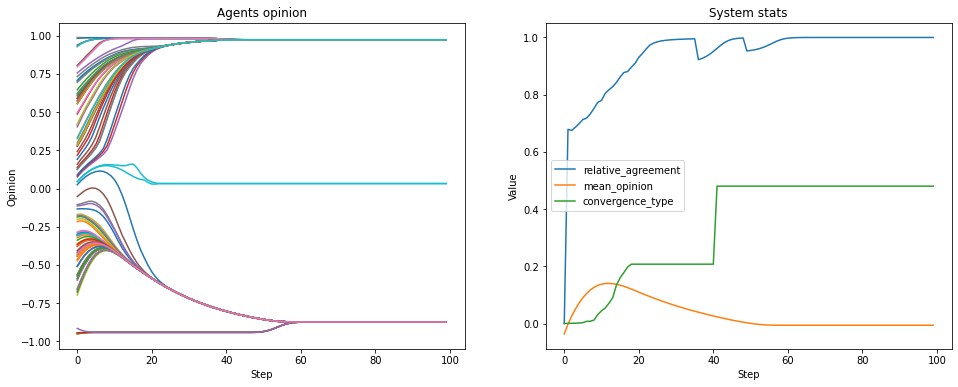

In [6]:
N_STEPS= 100
model = ContactModel(TOTAL_AGENT, EXTREMIST_PROPORTION, DELTA_POS_NEG,
                EXTREMIST_OPINION, UNCERTAINTY_EXTREMIST, AGENT_OPINION, UNCERTAINTY_AGENTS, MU)

opinion = [[] for x in range(TOTAL_AGENT)]

for i in tqdm(range(N_STEPS)):
    model.step()
    for agent in range(TOTAL_AGENT):
        ag = model.schedule.agents[agent]
        opinion[agent].append(ag.opinion)

plt.figure(figsize=(16, 6))
plt.subplot(121)
for i in range(len(opinion)):
    plt.plot(range(N_STEPS), opinion[i])
plt.title('Agents opinion')
plt.xlabel('Step')
plt.ylabel('Opinion')
    

df = model.datacollector.get_model_vars_dataframe()
agent_relative_agreement = df.agent_relative_agreement
agent_opinion = df.agent_opinion
convergence_type = df.convergence_type

plt.subplot(122)
plt.plot(range(N_STEPS), agent_relative_agreement, label='relative_agreement')
plt.plot(range(N_STEPS), agent_opinion, label='mean_opinion')
plt.plot(range(N_STEPS), convergence_type, label='convergence_type')
plt.title('System stats')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend(loc=6)

plt.show()

Вроде похоже на то, что описывается в статье. Давайте теперь создадим функцию, которая будет искать сходимость и функцию, которая будет выдавать тип сходимости.

In [7]:
def find_convergence_points(agent_relative_agreement):
    absolute = agent_relative_agreement > 1 - 1e-06
    try:
        absolute_convergence = absolute[absolute == 1].index[0]
    except IndexError:
        absolute_convergence = -1
    
    relative_convergence = -1
    diff = abs(agent_relative_agreement.diff().dropna()) < 5e-04
    
    tick = 0 

    for i in range(2, len(diff)):
        if diff.iloc[i]:
            tick += 1
            if tick == 15:
                relative_convergence = diff.iloc[[i-15]].index[0]
                break
        else: 
            tick = 0
            
    if relative_convergence==-1:
        print('Сходимость на заданом интервале не найдена')
    else:
        if absolute_convergence==-1:
            print('Найдена относительная сходимость на шаге {}'.format(relative_convergence))
        else:
            print('Найдена относительная сходимость на шаге {} и абсолютная на шаге {}'.format(relative_convergence, 
                                                                                         absolute_convergence))
    return absolute_convergence, relative_convergence

def find_convergence_type(convergence_type, absolute_convergence, relative_convergence):
    if absolute_convergence == -1:
        if relative_convergence == -1:
            try:
                conv = convergence_type[-1]
            except KeyError:
                conv = 0
        else:
            conv = convergence_type[relative_convergence]
    else:
        conv = convergence_type[absolute_convergence]
    if conv < 0.25:
        typee = 'ЦЕНТРАЛЬНОЕ МНЕНИЕ'
    elif conv > 0.75:
        typee = 'ОДНОСТОРОННИЙ ЭКСТРЕМИЗМ'
    else:
        typee = 'БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ'
    print('Система пришла к типу сходимости - {}, показатель типа сходимости - {}'.format(typee, round(conv, 2)))

Проверим как работает сходимость.

In [8]:
UNCERTAINTY_EXTREMIST = 0.1
EXTREMIST_OPINION = 0.1 # aka Ue
UNCERTAINTY_AGENTS = 1 # aka U
AGENT_OPINION = 0.2
DELTA_POS_NEG = 0.5 # aka sigma
MU = 0.5

In [9]:
def plot_results(TOTAL_AGENT, EXTREMIST_PROPORTION, DELTA_POS_NEG,
                EXTREMIST_OPINION, UNCERTAINTY_EXTREMIST, AGENT_OPINION,UNCERTAINTY_AGENTS, MU, N_STEPS=100):
    model = ContactModel(TOTAL_AGENT, EXTREMIST_PROPORTION, DELTA_POS_NEG,
                EXTREMIST_OPINION, UNCERTAINTY_EXTREMIST, AGENT_OPINION, UNCERTAINTY_AGENTS, MU)
    
    opinion = [[] for x in range(TOTAL_AGENT)]

    for i in tqdm(range(N_STEPS)):
        model.step()
        for agent in range(TOTAL_AGENT):
            ag = model.schedule.agents[agent]
            opinion[agent].append(ag.opinion)

    print('*'*120)
    print('''Параметры модели:
    TOTAL_AGENT (N) - {}
    EXTREMIST_PROPORTION (Pe) - {}
    EXTREMIST_OPINION (Ue) - {}
    UNCERTAINTY_AGENTS (U) - {}
    DELTA_POS_NEG (sigma) - {}
    MU - {}'''.format(TOTAL_AGENT, EXTREMIST_PROPORTION, EXTREMIST_OPINION, UNCERTAINTY_AGENTS, DELTA_POS_NEG, MU))        
            
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    for i in range(len(opinion)):
        plt.plot(range(N_STEPS), opinion[i])
    plt.title('Agents opinion')
    plt.xlabel('Step')
    plt.ylabel('Opinion')

    df = model.datacollector.get_model_vars_dataframe()
    agent_relative_agreement = df.agent_relative_agreement
    agent_opinion = df.agent_opinion
    convergence_type = df.convergence_type

    absolute_convergence, relative_convergence = find_convergence_points(agent_relative_agreement)
    if absolute_convergence != -1:
        plt.axline((absolute_convergence, -1), (absolute_convergence, 1), 
                   color="r", linestyle='--', label='absolute_convergence')
    if relative_convergence != -1:
        plt.axline((relative_convergence, -1), (relative_convergence, 1), 
                   color="b", linestyle=':', label='relative_convergence')
    plt.legend(loc='center right', bbox_to_anchor=(0.8,-0.2))
    find_convergence_type(convergence_type, absolute_convergence, relative_convergence)

    plt.subplot(122)
    plt.plot(range(N_STEPS), agent_relative_agreement, label='relative_agreement')
    plt.plot(range(N_STEPS), agent_opinion, label='mean_opinion')
    plt.plot(range(N_STEPS), convergence_type, label='convergence_type')
    plt.title('System stats')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.legend(loc=6)

    plt.show()

100%|██████████| 100/100 [00:01<00:00, 57.60it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 100
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 62 и абсолютная на шаге 72
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.48


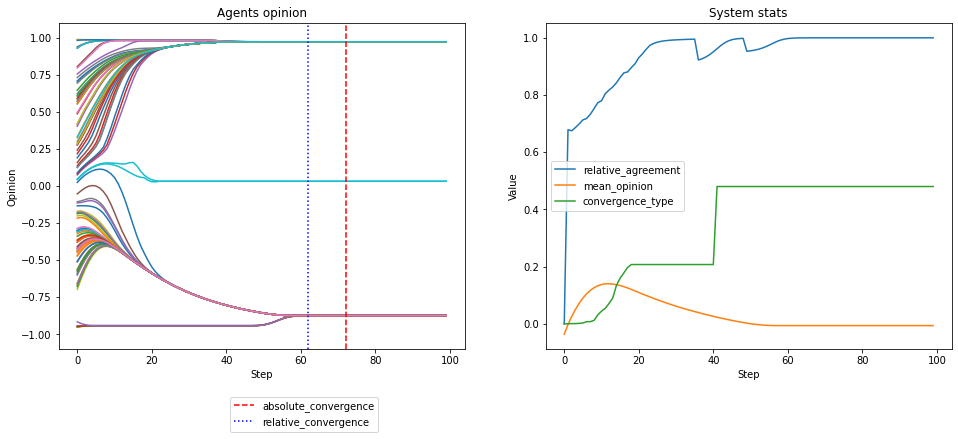

In [10]:
plot_results(TOTAL_AGENT, EXTREMIST_PROPORTION, DELTA_POS_NEG,
                EXTREMIST_OPINION, UNCERTAINTY_EXTREMIST, AGENT_OPINION, UNCERTAINTY_AGENTS, MU)

Теперь создадим функцию, которая позволит нам варьировать параметры системы. Однако, одновременно будем варьировать только один параметр, то есть закрепим все параметры, а один будем менять. Так мы сможем посмотреть больше вариантов параметров. Если варьировать все одновременно, то у нас получиться очень много различных расчетов и графиков. Даже если каждый параметр перебрать из 3-х вариантов, то при вариации 5 параметров получим $3^5$ различных графиков. Интересно на это будет смотреть? Я не думаю. Да и считать это не приятно. А так мы ограничимся по несколько вариантов и получим не их проихведение, а сумму

In [11]:
TOTAL_AGENT = 1000 # aka N
EXTREMIST_PROPORTION = 0.1 # aka Pe
UNCERTAINTY_EXTREMIST = 0.1
EXTREMIST_OPINION = 0.1 # aka Ue
UNCERTAINTY_AGENTS = 1 # aka U
AGENT_OPINION = 0.2
DELTA_POS_NEG = 0.5 # aka sigma
MU = 0.5

In [12]:
def plot_results_with_params(Pe, Ue, U, sigma, MUs):
    TOTAL_AGENT = 1000
    for EXT_PR in Pe:
        print('Варьируемый параметр - Pe')
        plot_results(TOTAL_AGENT, EXT_PR, DELTA_POS_NEG,
                     EXTREMIST_OPINION, UNCERTAINTY_EXTREMIST, AGENT_OPINION, UNCERTAINTY_AGENTS, MU)
    for EXT_OP in Ue:
        print('Варьируемый параметр - Ue')
        plot_results(TOTAL_AGENT, EXTREMIST_PROPORTION, DELTA_POS_NEG,
                EXT_OP, UNCERTAINTY_EXTREMIST, AGENT_OPINION, UNCERTAINTY_AGENTS, MU)
    for UNC_AG in U:
        print('Варьируемый параметр - U')
        plot_results(TOTAL_AGENT, EXTREMIST_PROPORTION, DELTA_POS_NEG,
                EXTREMIST_OPINION, UNCERTAINTY_EXTREMIST, AGENT_OPINION, UNC_AG, MU)
    for DELTA in sigma:
        print('Варьируемый параметр - sigma')
        plot_results(TOTAL_AGENT, EXTREMIST_PROPORTION, DELTA,
                EXTREMIST_OPINION, UNCERTAINTY_EXTREMIST, AGENT_OPINION, UNCERTAINTY_AGENTS, MU)
    for mu in MUs:
        print('Варьируемый параметр - MU')
        plot_results(TOTAL_AGENT, EXTREMIST_PROPORTION, DELTA_POS_NEG,
                EXTREMIST_OPINION, UNCERTAINTY_EXTREMIST, AGENT_OPINION, UNCERTAINTY_AGENTS, mu)

In [13]:
Pe = [0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
Ue = [0.05, 0.1, 0.15, 0.2]
U = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6,1.8, 2]
sigma = [0.5, 0.6, 0.7, 0.8, 0.9]
MUs = [0.1, 0.2, 0.3, 0.4, 0.5]

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - Pe


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.025
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 31 и абсолютная на шаге 43
Система пришла к типу сходимости - ЦЕНТРАЛЬНОЕ МНЕНИЕ, показатель типа сходимости - 0.0


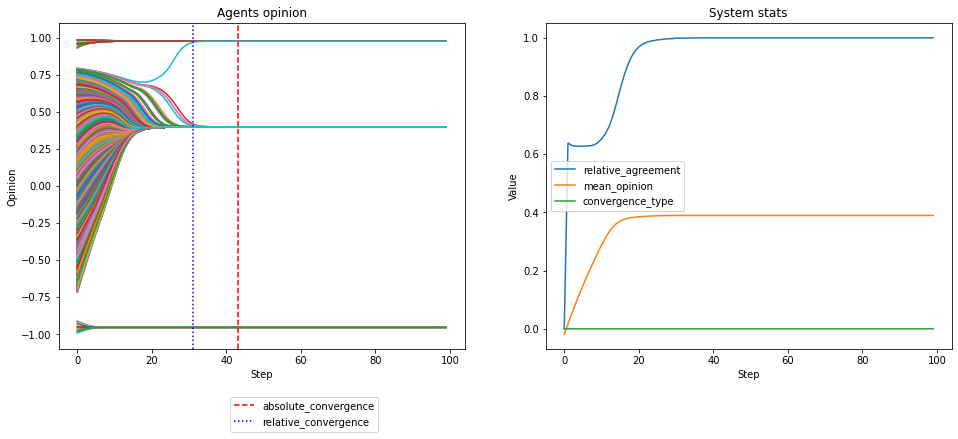

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - Pe


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.05
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 30 и абсолютная на шаге 41
Система пришла к типу сходимости - ЦЕНТРАЛЬНОЕ МНЕНИЕ, показатель типа сходимости - 0.0


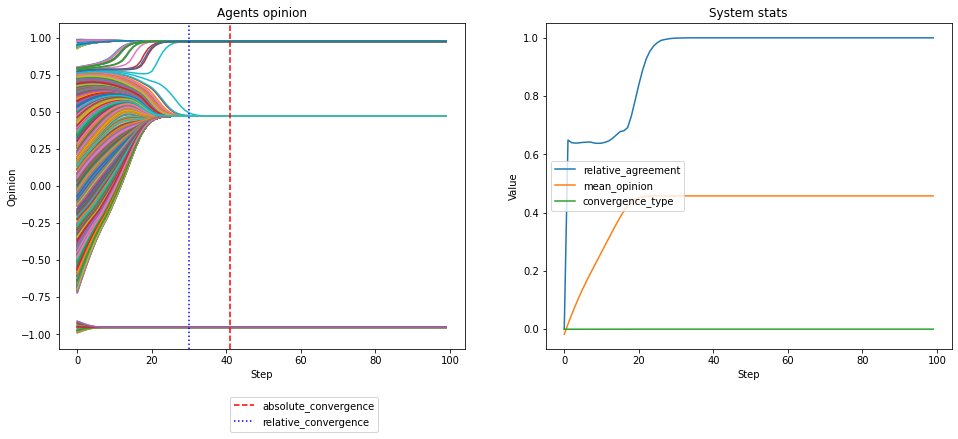

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - Pe


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 80 и абсолютная на шаге 90
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.5


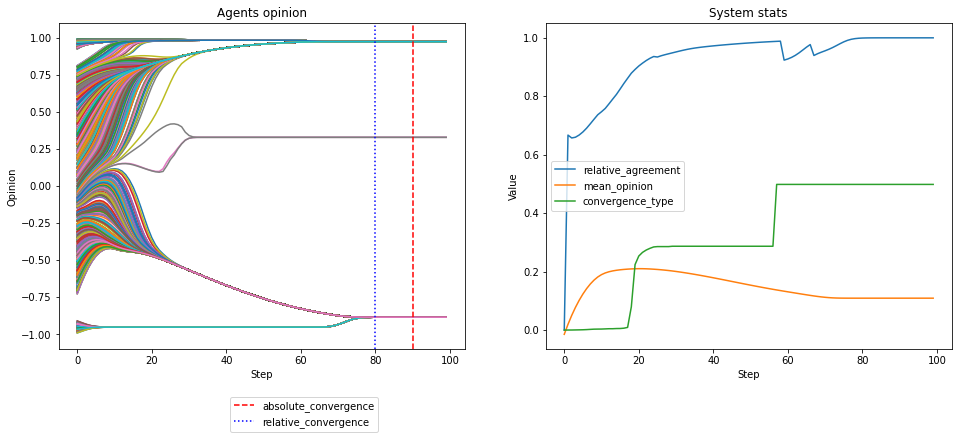

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - Pe


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.15
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 44 и абсолютная на шаге 54
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.49


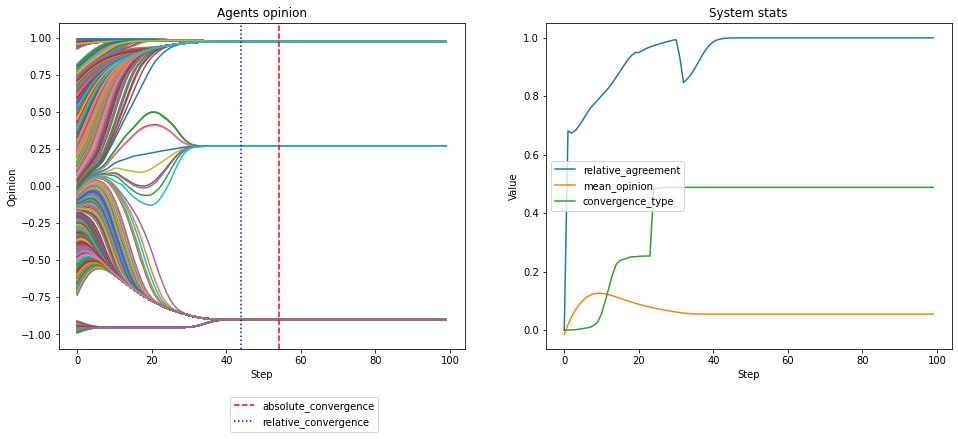

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - Pe


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.2
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 37 и абсолютная на шаге 47
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.48


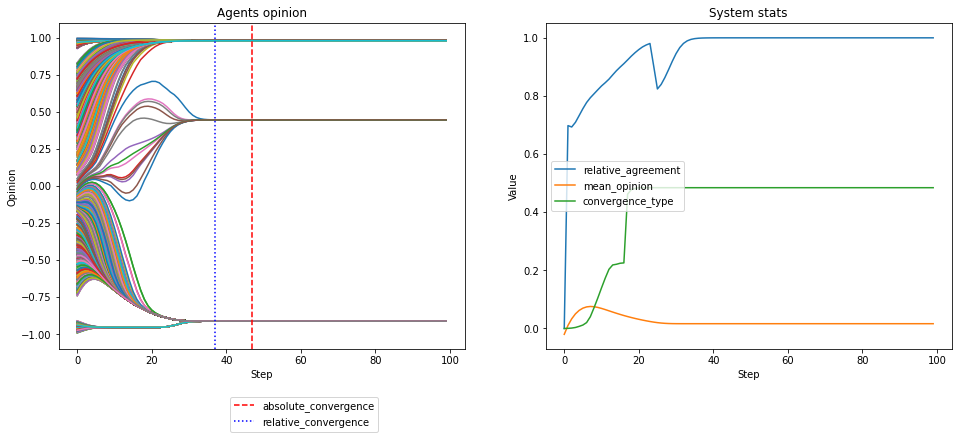

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - Pe


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.25
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 33 и абсолютная на шаге 43
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.48


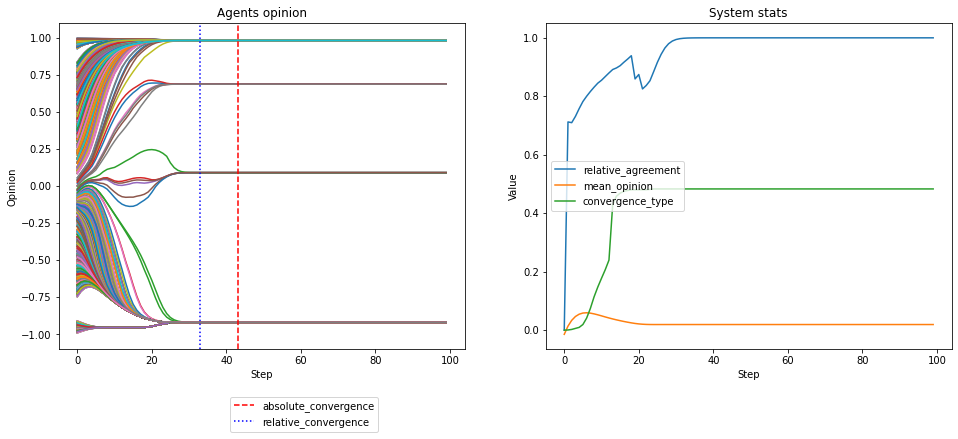

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - Pe


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.3
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 50 и абсолютная на шаге 60
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.48


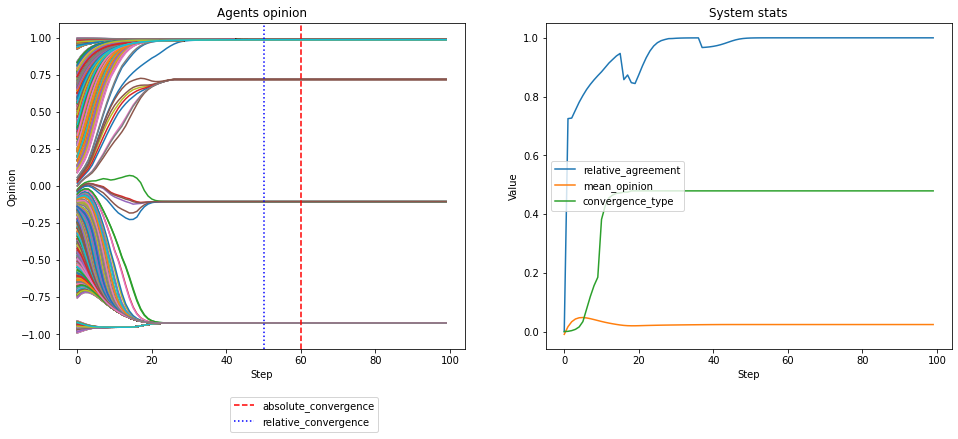

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - Ue


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.05
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5


No handles with labels found to put in legend.


Сходимость на заданом интервале не найдена
Система пришла к типу сходимости - ЦЕНТРАЛЬНОЕ МНЕНИЕ, показатель типа сходимости - 0


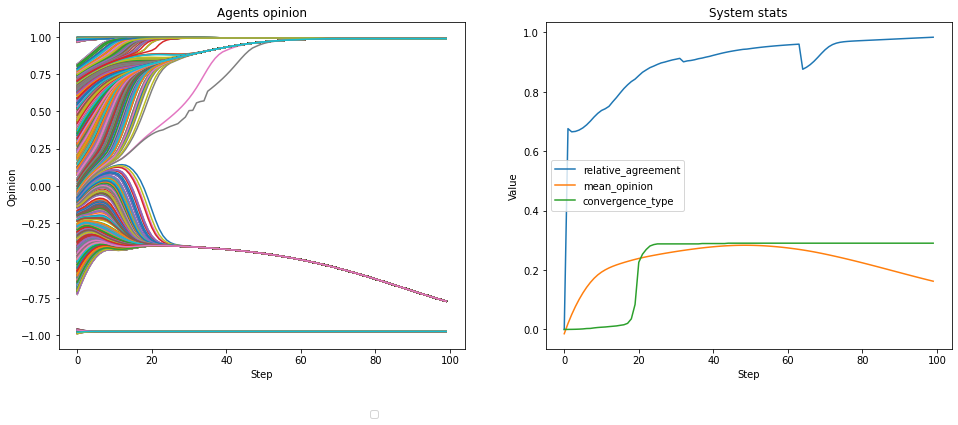

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - Ue


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 80 и абсолютная на шаге 90
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.5


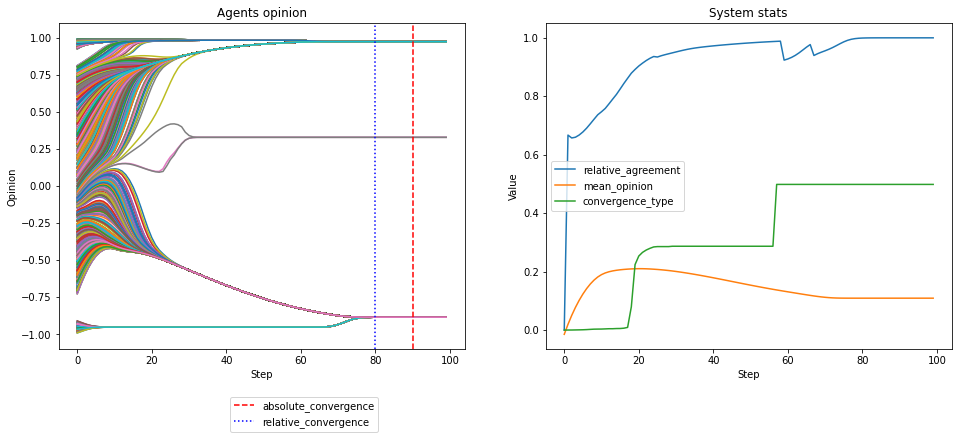

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - Ue


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.15
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 71 и абсолютная на шаге 81
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.5


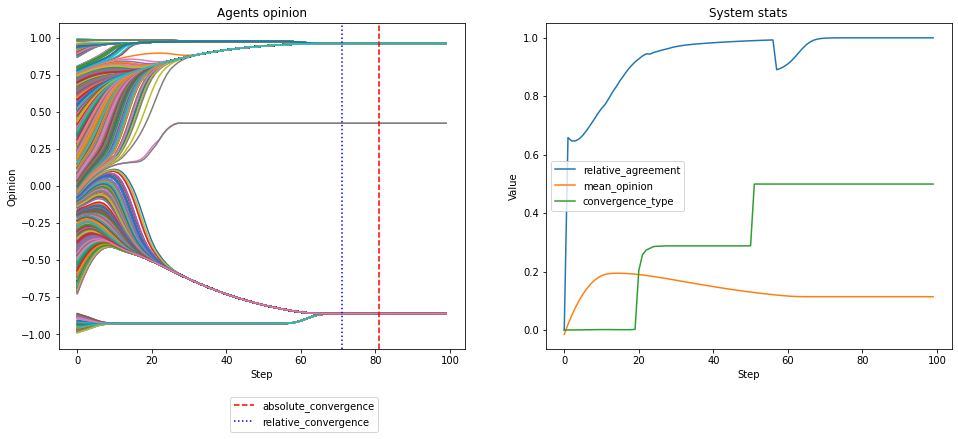

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - Ue


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.2
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 67 и абсолютная на шаге 77
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.5


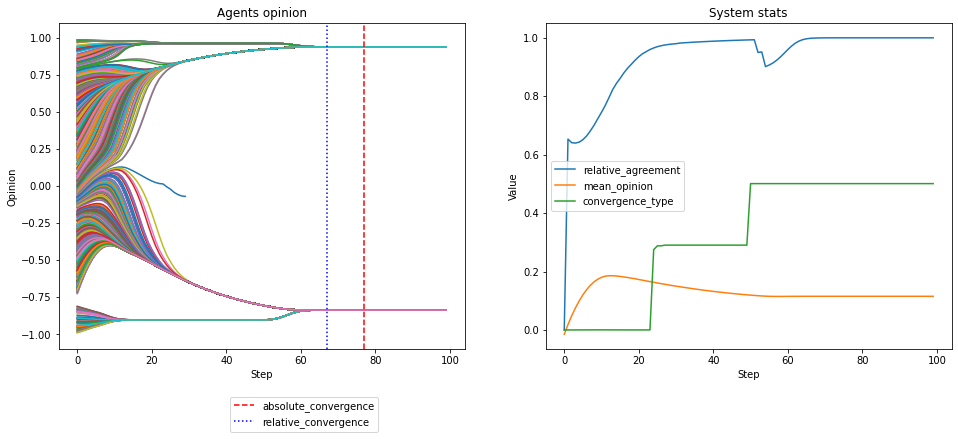

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - U


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 0.2
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 51 и абсолютная на шаге 59
Система пришла к типу сходимости - ЦЕНТРАЛЬНОЕ МНЕНИЕ, показатель типа сходимости - 0.0


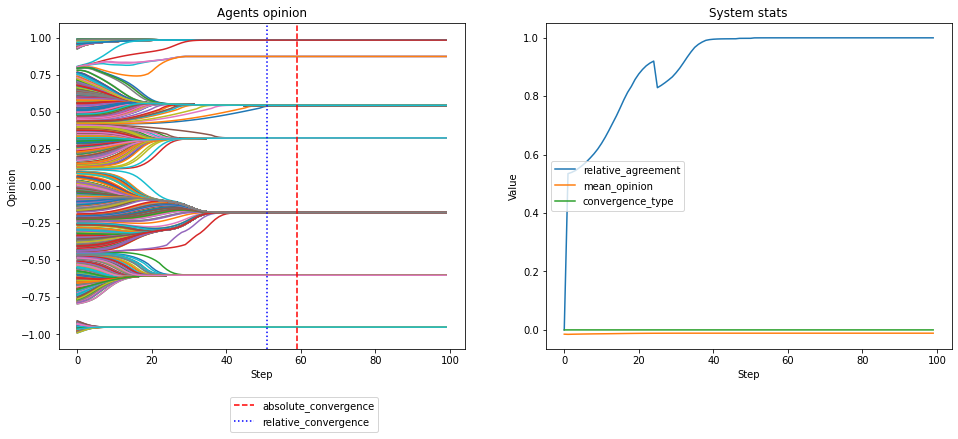

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - U


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 0.4
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 60 и абсолютная на шаге 70
Система пришла к типу сходимости - ЦЕНТРАЛЬНОЕ МНЕНИЕ, показатель типа сходимости - 0.09


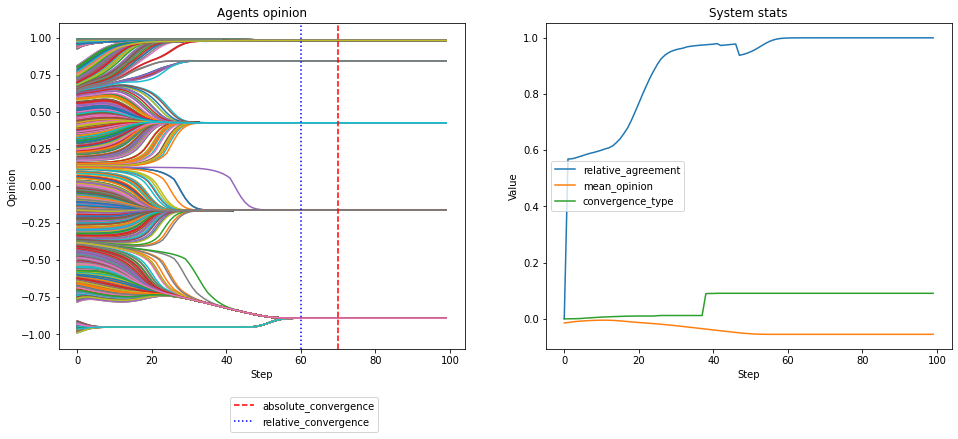

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - U


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 0.6
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 58
Система пришла к типу сходимости - ЦЕНТРАЛЬНОЕ МНЕНИЕ, показатель типа сходимости - 0.17


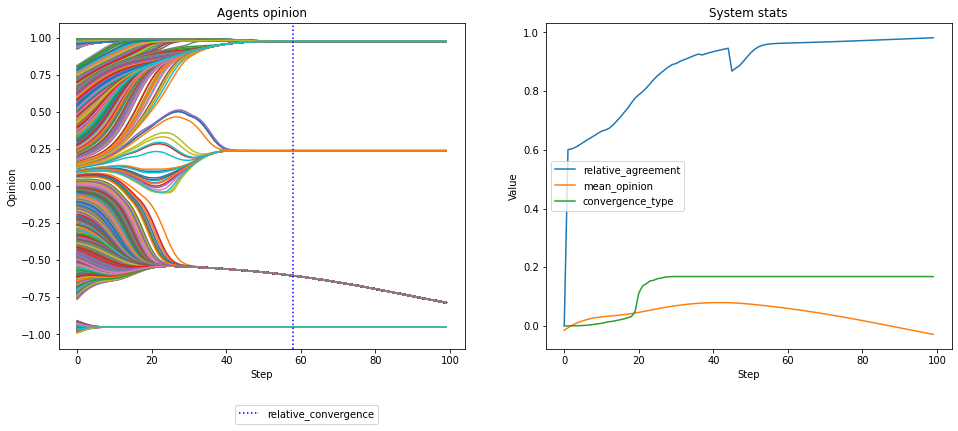

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - U


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 0.8
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 68 и абсолютная на шаге 78
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.49


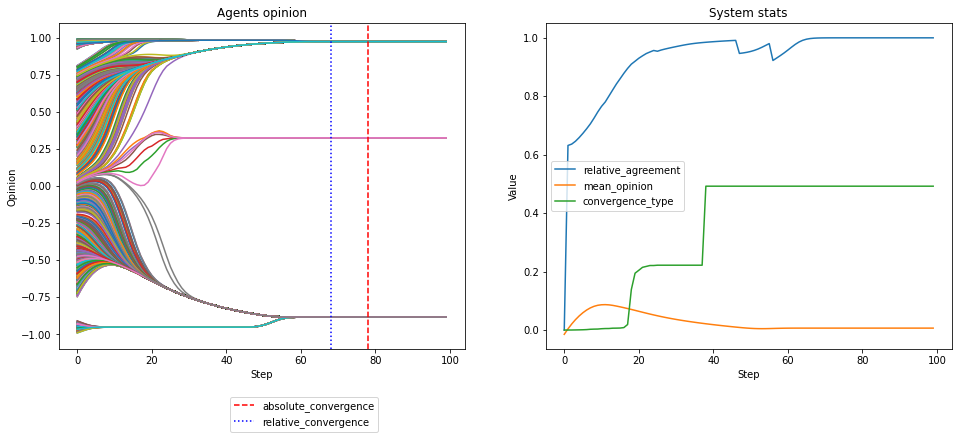

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - U


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 80 и абсолютная на шаге 90
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.5


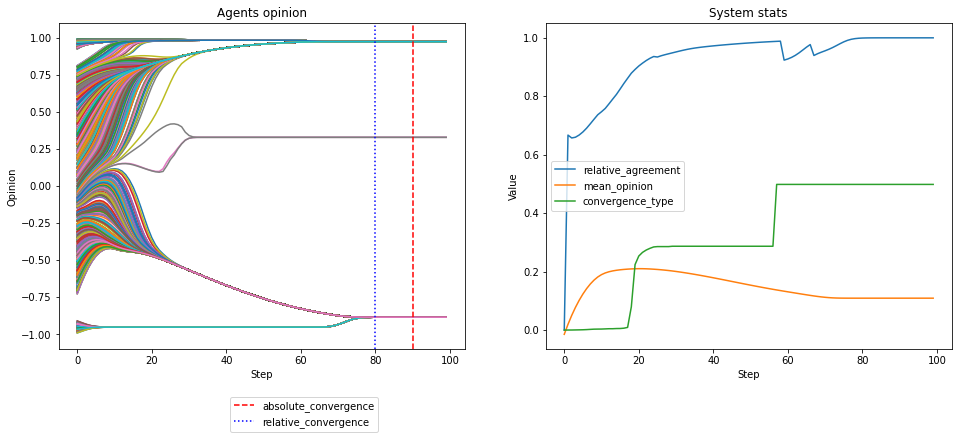

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - U


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1.2
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 80 и абсолютная на шаге 90
Система пришла к типу сходимости - ОДНОСТОРОННИЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 1.0


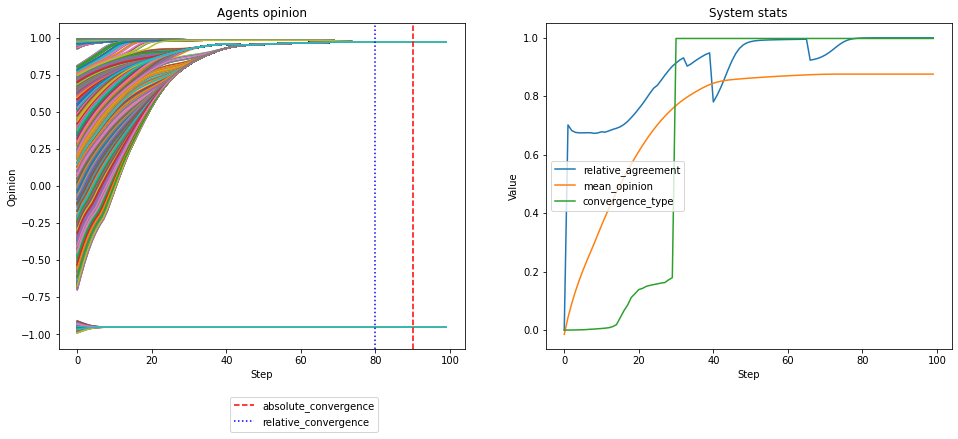

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - U


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1.4
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 64 и абсолютная на шаге 74
Система пришла к типу сходимости - ОДНОСТОРОННИЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 1.0


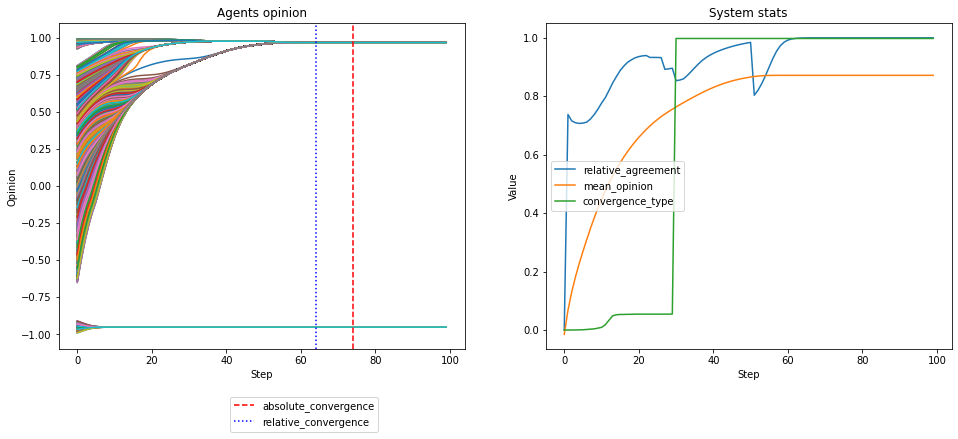

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - U


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1.6
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 59 и абсолютная на шаге 69
Система пришла к типу сходимости - ОДНОСТОРОННИЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 1.0


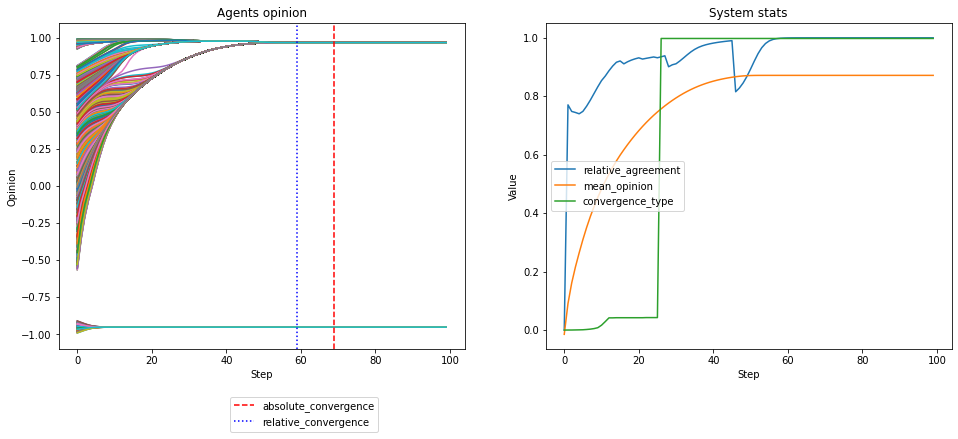

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - U


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1.8
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 57 и абсолютная на шаге 67
Система пришла к типу сходимости - ОДНОСТОРОННИЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 1.0


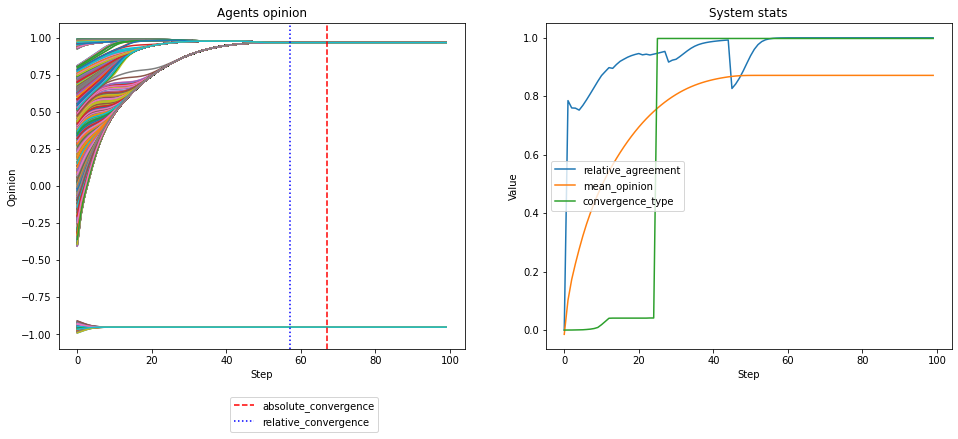

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - U


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 2
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 57 и абсолютная на шаге 67
Система пришла к типу сходимости - ОДНОСТОРОННИЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 1.0


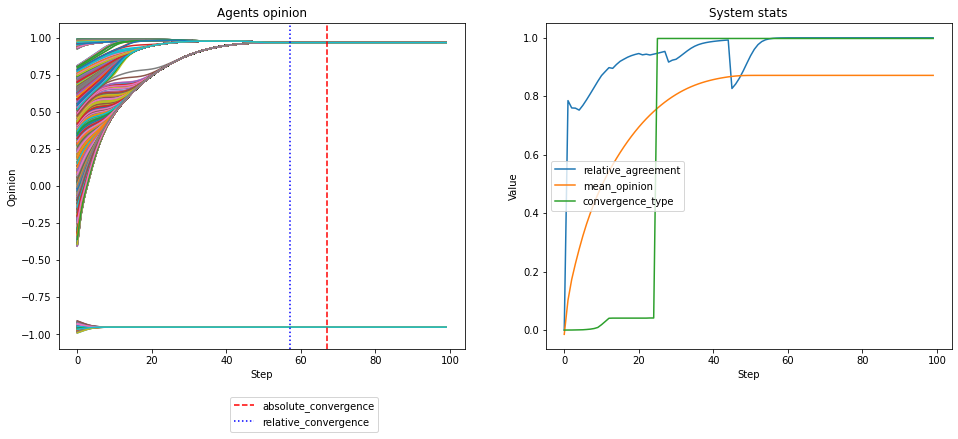

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - sigma


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 80 и абсолютная на шаге 90
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.5


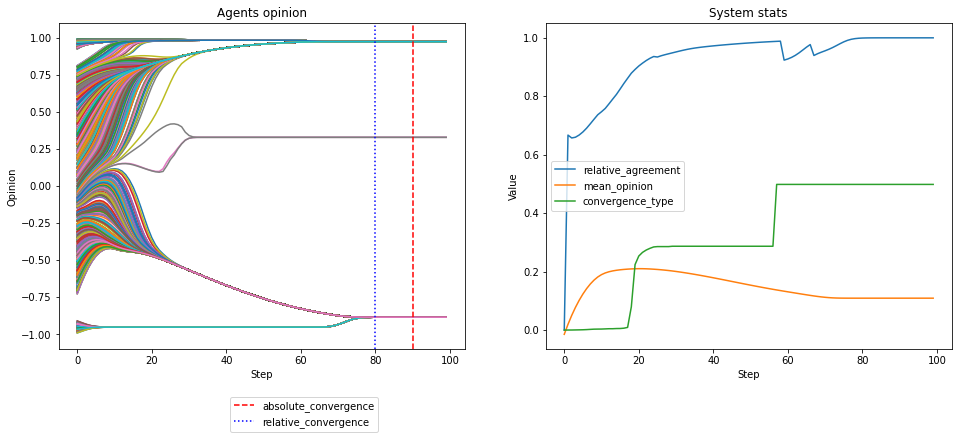

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - sigma


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.6
    MU - 0.5
Найдена относительная сходимость на шаге 56 и абсолютная на шаге 99
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.5


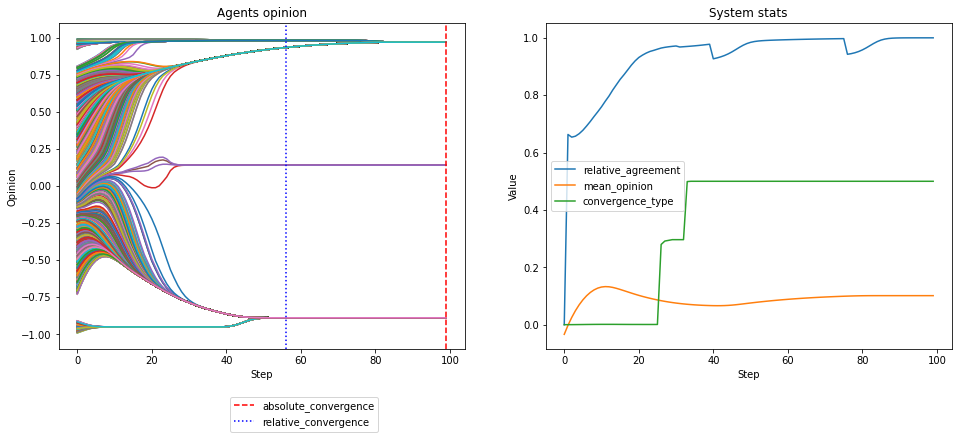

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - sigma


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.7
    MU - 0.5
Найдена относительная сходимость на шаге 45 и абсолютная на шаге 55
Система пришла к типу сходимости - ЦЕНТРАЛЬНОЕ МНЕНИЕ, показатель типа сходимости - 0.2


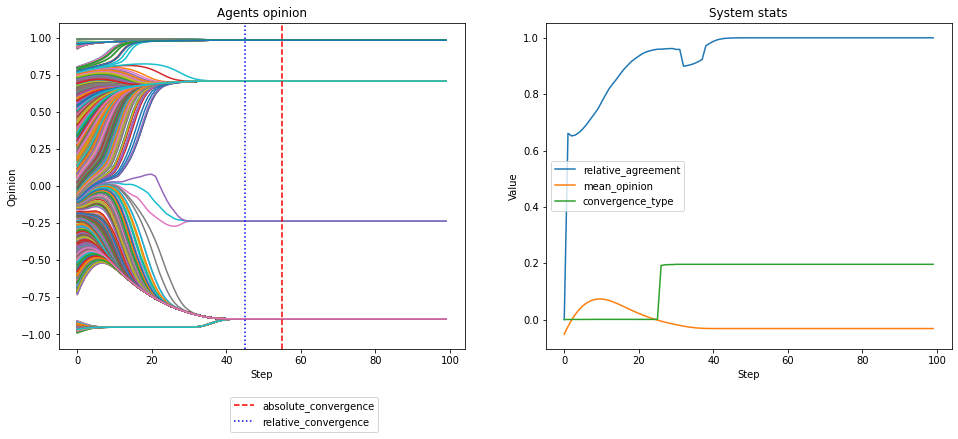

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - sigma


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.8
    MU - 0.5
Найдена относительная сходимость на шаге 41
Система пришла к типу сходимости - ЦЕНТРАЛЬНОЕ МНЕНИЕ, показатель типа сходимости - 0.19


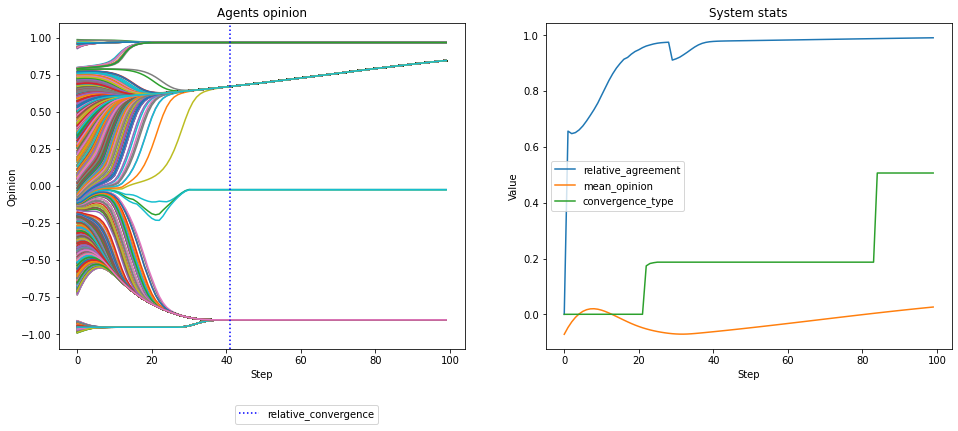

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - sigma


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.9
    MU - 0.5
Найдена относительная сходимость на шаге 38 и абсолютная на шаге 48
Система пришла к типу сходимости - ЦЕНТРАЛЬНОЕ МНЕНИЕ, показатель типа сходимости - 0.18


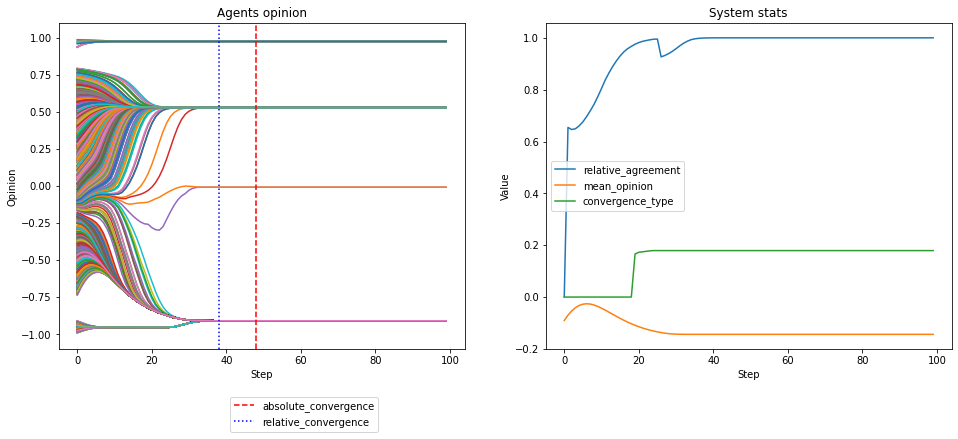

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - MU


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.1


No handles with labels found to put in legend.


Сходимость на заданом интервале не найдена
Система пришла к типу сходимости - ЦЕНТРАЛЬНОЕ МНЕНИЕ, показатель типа сходимости - 0


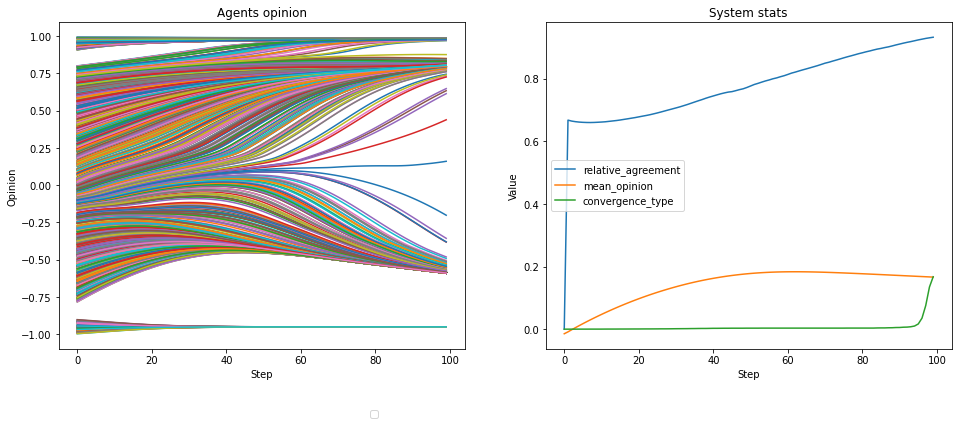

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - MU


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.2


No handles with labels found to put in legend.


Сходимость на заданом интервале не найдена
Система пришла к типу сходимости - ЦЕНТРАЛЬНОЕ МНЕНИЕ, показатель типа сходимости - 0


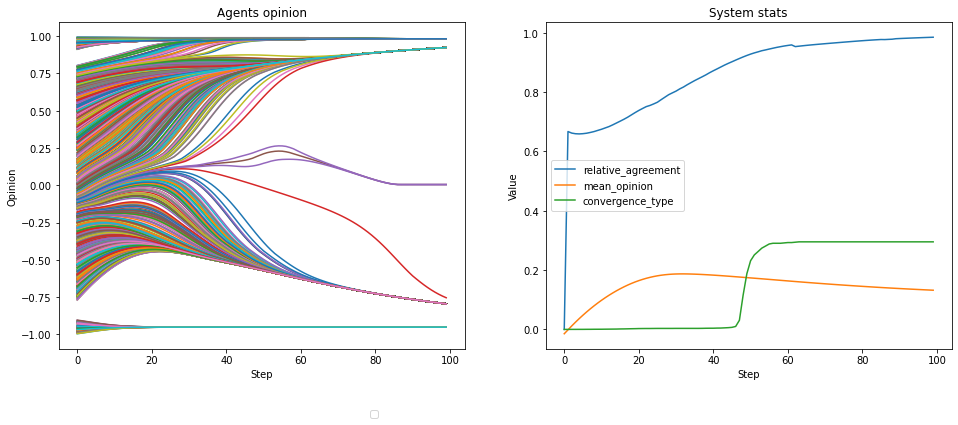

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - MU


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.3
Найдена относительная сходимость на шаге 72
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.29


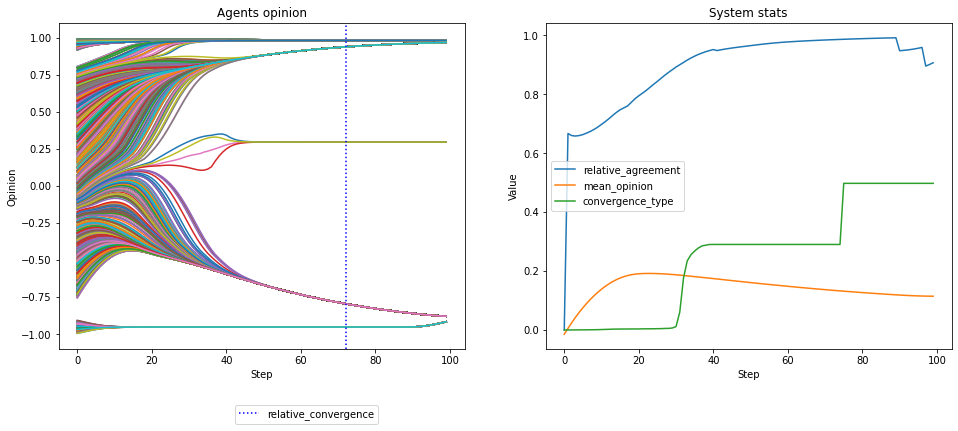

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - MU


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.4


No handles with labels found to put in legend.


Сходимость на заданом интервале не найдена
Система пришла к типу сходимости - ЦЕНТРАЛЬНОЕ МНЕНИЕ, показатель типа сходимости - 0


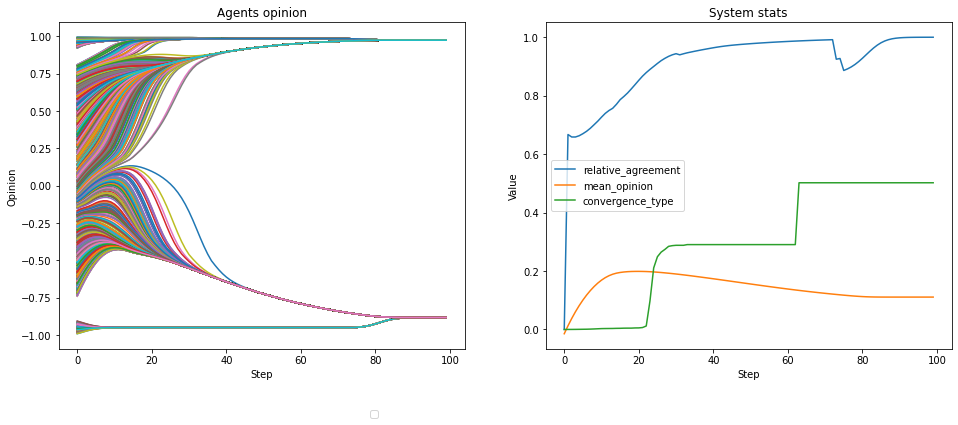

  0%|          | 0/100 [00:00<?, ?it/s]

Варьируемый параметр - MU


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


************************************************************************************************************************
Параметры модели:
    TOTAL_AGENT (N) - 1000
    EXTREMIST_PROPORTION (Pe) - 0.1
    EXTREMIST_OPINION (Ue) - 0.1
    UNCERTAINTY_AGENTS (U) - 1
    DELTA_POS_NEG (sigma) - 0.5
    MU - 0.5
Найдена относительная сходимость на шаге 80 и абсолютная на шаге 90
Система пришла к типу сходимости - БИПОЛЯРНЫЙ ЭКСТРЕМИЗМ, показатель типа сходимости - 0.5


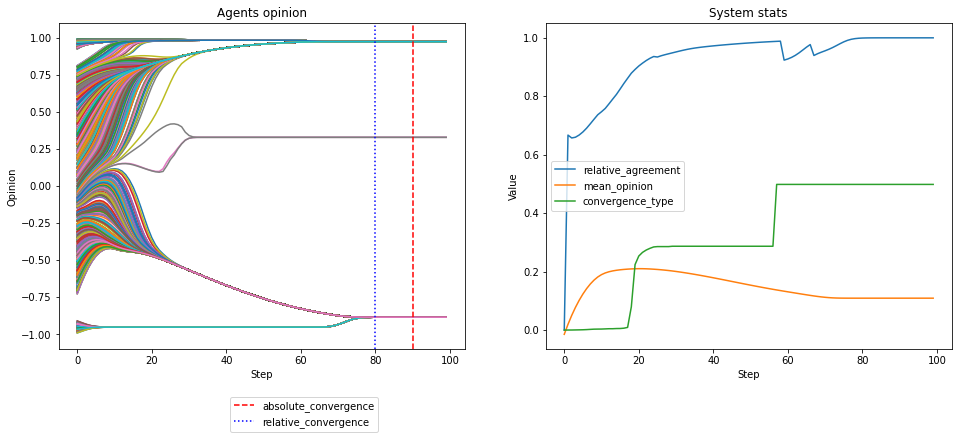

Wall time: 30min 25s


In [14]:
%%time
plot_results_with_params(Pe, Ue, U, sigma, MUs)

Выводы:

1. Вариация параметра Pe (доли экстремистов) - если экстремистов слишком мало, то общее состояние системы приходит к центральному мнению, поскольку экстремистов слишком мало для того, чтобы оказать существенное влияние на общее положение системы. Если экстремистов много, то система сходится к биполярному мнению, они оказывают существенное влияние на общее мнение.
2. Вариация параметра Ue (изначальная неопределенность экстремистов) - особо не влияет на систему. Система сходится к биполярному мнению. Экстремисты могут только проявлять большую 'лояльность', те. быть чуть менее положительными или отрицательными.
3. Вариация параметра U (изначальная неопределенность обычных экстремистов) - при малом значение параметра, агенты кластеризуются в небольшие группы со своей локальной позицией. При увеличении параметра - кластеров становится меньше до тех пор, пока система не выйдет к биполярному мнению. Чем больше данный параметр, тем меньше становится агентов с центральным мнением (нейтральным). При очень большом параметре наблюдается односторонний экстремизм, почему так происходит - загадка. Возможно дело в фиксированном сиде и особенностях реализации на питоне.
4. Вариация параметра sigma (доля положительный и отрицательных экстремистов) - очевидно, что при увеличении доли одного типа экстремизма система должна сходится к одностороннему экстремизму, но поскольку мнение агентов недостаточно неопределенно, то мы имеем сходимость с биполярной позицией или центральным мнением. Если бы доля экстремистов и неопределенность обычных агентов была больше, то мы, определенно, получили бы биполярный экстремизм.
5. Вариация параметра MU (интенсивность взаимодействий) - не влияет на вид сходимости. Оказывает, только существенное влияние на скорость сходимости системы. 

Действительно, небольшое количество радикалов может оказать существенное влияние на общественное мнение, что и показывает модель. Хорошо бы посмотреть на изменение мнения на сетке и как оно отличается от моей модели (думаю, что не сильно). Но видимо не в моей работе)